**Piza Nava Vladimir**

**Enlace Github: https://github.com/vladi-13/ExamenFinalSIS421**

**Enlace Repositorio: https://www.kaggle.com/datasets/preatcher/standard-ocr-dataset** 

Este bloque inicial prepara el entorno para un proyecto de Deep Learning con imágenes. Importa librerías para procesamiento, entrenamiento, visualización y evaluación de modelos, establece una semilla para garantizar resultados reproducibles y comprueba si hay GPU disponible para acelerar el entrenamiento.

In [16]:
# Bloque 1: Importaciones y Configuración Inicial

import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_model_optimization as tfmot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import cv2
import os
import zipfile
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Configuración general
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU disponible: {len(tf.config.list_physical_devices('GPU')) > 0}")

TensorFlow version: 2.12.0
GPU disponible: False


Este bloque carga un dataset de imágenes OCR desde carpetas locales, donde cada subcarpeta representa una clase. Las imágenes se convierten a escala de grises, se redimensionan a un tamaño uniforme y se almacenan junto con sus etiquetas numéricas. Luego, se imprime información general del dataset y se visualiza la distribución de clases para entender cómo están representadas.

Total de imágenes cargadas: 20628
Número de clases: 36
Clases: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']...


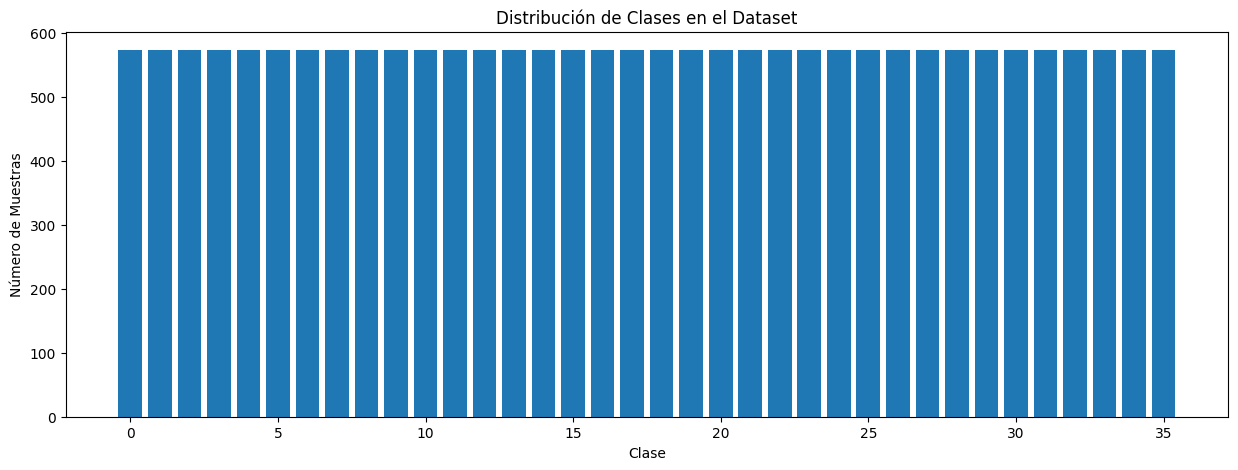

In [17]:
# Bloque 2: Exploración del dataset y procesamiento de imagenes

def load_and_explore_dataset(dataset_path, target_size=(64, 64)):
    """Carga y explora el dataset OCR desde una carpeta local, redimensionando las imágenes."""

    # Verifica que la ruta del dataset exista
    if not os.path.exists(dataset_path):
        print(f"Por favor verifica la ruta del dataset: {dataset_path}")
        return None, None, None

    images = []       # Lista para almacenar las imágenes procesadas
    labels = []       # Lista para las etiquetas (clases en formato numérico)
    class_names = []  # Lista con los nombres de las clases (nombres de carpetas)

    # Recorre cada subcarpeta del dataset (cada una representa una clase)
    for class_dir in sorted(os.listdir(dataset_path)):
        class_path = os.path.join(dataset_path, class_dir)
        if os.path.isdir(class_path):
            class_names.append(class_dir)  # Guarda el nombre de la clase
            class_idx = len(class_names) - 1  # Asigna un índice numérico a la clase

            # Recorre las imágenes de la clase
            for img_file in os.listdir(class_path):
                # Solo acepta archivos con formato de imagen
                if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    img_path = os.path.join(class_path, img_file)
                    # Lee la imagen en escala de grises
                    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                    if img is not None:
                        # Redimensiona la imagen al tamaño deseado
                        img_resized = cv2.resize(img, target_size)
                        images.append(img_resized)     # Agrega imagen a la lista
                        labels.append(class_idx)       # Agrega la etiqueta numérica

    # Imprime estadísticas generales del dataset
    print(f"Total de imágenes cargadas: {len(images)}")
    print(f"Número de clases: {len(class_names)}")
    print(f"Clases: {class_names[:10]}...")  # Muestra solo las primeras 10 clases

    return np.array(images), np.array(labels), class_names


# Ruta local del dataset (ajústala si es necesario)
DATASET_PATH = "dataset/data/training_data"

# Carga el dataset: imágenes (X), etiquetas (y) y nombres de clases
images, labels, class_names = load_and_explore_dataset(DATASET_PATH, target_size=(64, 64))


# Visualiza la cantidad de muestras por clase (distribución de clases)
if images is not None:
    unique, counts = np.unique(labels, return_counts=True)  # Cuenta ocurrencias por clase
    plt.figure(figsize=(15, 5))
    plt.bar(range(len(counts)), counts)
    plt.title('Distribución de Clases en el Dataset')
    plt.xlabel('Clase')
    plt.ylabel('Número de Muestras')
    plt.show()


Este bloque preprocesa las imágenes para que estén listas para entrenar un modelo. Normaliza los valores de píxeles, adapta el tamaño y formato del tensor, convierte las etiquetas en formato one-hot, y divide los datos en conjuntos de entrenamiento, validación y prueba. Finalmente, muestra una vista previa visual de algunas imágenes preprocesadas.



Train: (14439, 64, 64, 1), Val: (3094, 64, 64, 1), Test: (3095, 64, 64, 1)


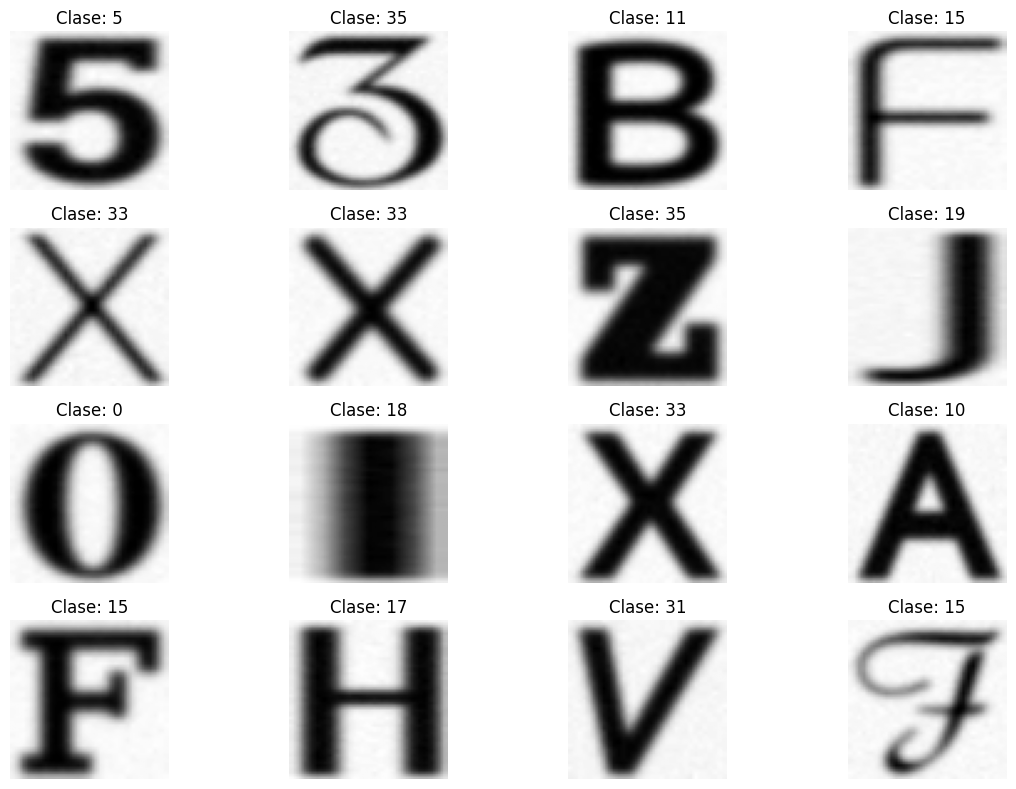

In [ ]:
# Bloque 3: Preprocesamiento de datos

def preprocess_data(images, labels, target_size=(64, 64)):
    """Redimensiona y normaliza las imágenes a [0,1] y agrega un canal para CNN"""
    processed_images = []

    for img in images:
        # Redimensionar imagen al tamaño objetivo (por si no estaban todas iguales)
        img_resized = cv2.resize(img, target_size)
        # Normalizar valores de píxeles a rango [0, 1]
        img_normalized = img_resized.astype(np.float32) / 255.0
        # Expandir dimensión para tener formato (alto, ancho, canales) = (64, 64, 1)
        img_final = np.expand_dims(img_normalized, axis=-1)
        processed_images.append(img_final)

    return np.array(processed_images)


# Preprocesar los datos solo si se cargaron imágenes correctamente
if images is not None:
    # X son las imágenes normalizadas y con canal extra
    X = preprocess_data(images, labels)

    # y son las etiquetas convertidas a one-hot encoding
    y = tf.keras.utils.to_categorical(labels, num_classes=len(class_names))

    # Dividir los datos: 70% entrenamiento, 15% validación, 15% prueba
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=0.3, random_state=SEED, stratify=y  # 30% para val + test
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, random_state=SEED, stratify=y_temp  # mitad y mitad
    )

    # Mostrar dimensiones finales
    print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

    # Mostrar 16 imágenes de entrenamiento con su clase
    plt.figure(figsize=(12, 8))
    for i in range(16):
        plt.subplot(4, 4, i+1)
        plt.imshow(X_train[i].squeeze(), cmap='gray')  # Quitar canal para mostrar
        plt.title(f'Clase: {np.argmax(y_train[i])}')   # Mostrar clase correspondiente
        plt.axis('off')
    plt.tight_layout()
    plt.show()

Este bloque define y compila un modelo de red neuronal profundo llamado "modelo profesor", basado en EfficientNetB0, diseñado para ser robusto y preciso. Se utiliza como referencia para entrenar modelos más ligeros en procesos como distilación. El modelo incluye capas densas, normalización y dropout para mejorar el rendimiento y reducir el sobreajuste.

In [ ]:
# Bloque 4: Creación del Modelo Profesor

def create_teacher_model(input_shape, num_classes):
    """Crea un modelo profesor robusto basado en EfficientNetB0"""

    # Cargar EfficientNetB0 sin su clasificador final y sin pesos preentrenados
    base_model = tf.keras.applications.EfficientNetB0(
        input_shape=input_shape,
        include_top=False,     # No incluir la capa de clasificación final
        weights=None,          # Se entrenará desde cero
        pooling='avg'          # Promedio global para generar vector de salida
    )

    # Construcción del modelo completo usando capas adicionales
    model = tf.keras.Sequential([
        base_model,                               # Modelo base como extractor de características
        tf.keras.layers.Dropout(0.3),             # Dropout para evitar sobreajuste
        tf.keras.layers.Dense(512, activation='relu'),   # Capa densa intermedia
        tf.keras.layers.BatchNormalization(),     # Normalización para estabilidad
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(256, activation='relu'),   # Otra capa densa más pequeña
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(num_classes, activation='softmax')  # Salida: clasificación multiclase
    ])
    
    return model


# Crear y compilar el modelo profesor si se cargaron imágenes
if images is not None:
    INPUT_SHAPE = X_train.shape[1:]      # (64, 64, 1)
    NUM_CLASSES = len(class_names)       # Total de clases

    teacher_model = create_teacher_model(INPUT_SHAPE, NUM_CLASSES)

    # Compilar el modelo con optimizador AdamW y métricas de top-1 y top-3
    teacher_model.compile(
        optimizer=tf.keras.optimizers.AdamW(learning_rate=0.001, weight_decay=1e-5),
        loss='categorical_crossentropy',   # Para clasificación multiclase
        metrics=[
            'accuracy',                   # Precisión clásica (Top-1)
            tf.keras.metrics.TopKCategoricalAccuracy(k=3, name='top_3_accuracy')  # Precisión Top-3
        ]
    )

    print("Modelo Profesor creado:")
    teacher_model.summary()  # Muestra la arquitectura del modelo

Modelo Profesor creado:
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 1280)             4048991   
                                                                 
 dropout_6 (Dropout)         (None, 1280)              0         
                                                                 
 dense_5 (Dense)             (None, 512)               655872    
                                                                 
 batch_normalization_7 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dropout_7 (Dropout)         (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 256)               131328    
                              

Este bloque entrena el modelo profesor utilizando callbacks para optimizar el proceso: detiene el entrenamiento si no hay mejoras, reduce la tasa de aprendizaje si el modelo se estanca, y guarda el mejor modelo basado en precisión de validación. Al final, evalúa el rendimiento en el conjunto de prueba y visualiza las curvas de precisión y pérdida para analizar el comportamiento del entrenamiento.

Entrenando Modelo Profesor...
Epoch 1/20
57/57 [==============================] - ETA: 0s - loss: 3.2599 - accuracy: 0.1763 - top_3_accuracy: 0.3407
Epoch 1: val_accuracy improved from -inf to 0.02780, saving model to teacher_model_best.h5
57/57 [==============================] - 133s 2s/step - loss: 3.2599 - accuracy: 0.1763 - top_3_accuracy: 0.3407 - val_loss: 3.5942 - val_accuracy: 0.0278 - val_top_3_accuracy: 0.0834 - lr: 0.0010
Epoch 2/20
57/57 [==============================] - ETA: 0s - loss: 1.1643 - accuracy: 0.6718 - top_3_accuracy: 0.8693
Epoch 2: val_accuracy did not improve from 0.02780
57/57 [==============================] - 102s 2s/step - loss: 1.1643 - accuracy: 0.6718 - top_3_accuracy: 0.8693 - val_loss: 3.6634 - val_accuracy: 0.0278 - val_top_3_accuracy: 0.0831 - lr: 0.0010
Epoch 3/20
57/57 [==============================] - ETA: 0s - loss: 0.4898 - accuracy: 0.8579 - top_3_accuracy: 0.9613
Epoch 3: val_accuracy did not improve from 0.02780
57/57 [===================

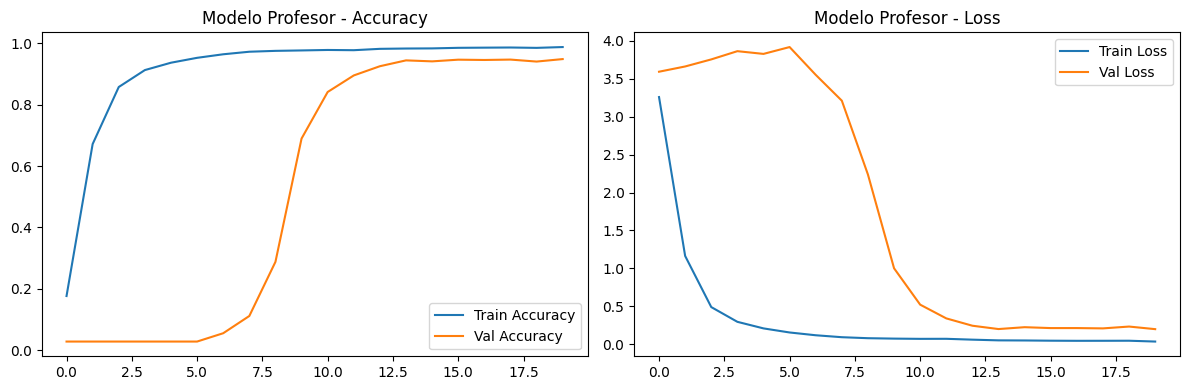

In [ ]:
# Bloque 5: Entrenamiento del Profesor

def create_callbacks(model_name):
    """Define callbacks para controlar el entrenamiento"""
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',   # Observa la precisión en validación
            patience=10,              # Si no mejora en 10 épocas, se detiene
            restore_best_weights=True,  # Recupera los mejores pesos
            verbose=1
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',       # Reduce el LR si la pérdida se estanca
            factor=0.5,               # Reduce a la mitad
            patience=5,               # Espera 5 épocas sin mejora
            min_lr=1e-7,              # No baja más de este valor
            verbose=1
        ),
        tf.keras.callbacks.ModelCheckpoint(
            f'{model_name}_best.h5',  # Guarda el mejor modelo en este archivo
            monitor='val_accuracy',
            save_best_only=True,      # Solo guarda si mejora
            verbose=1
        )
    ]
    return callbacks


# Entrena el modelo profesor si se cargaron datos
if images is not None:
    print("Entrenando Modelo Profesor...")
    
    # Crear callbacks definidos arriba
    teacher_callbacks = create_callbacks('teacher_model')

    # Entrenar el modelo
    teacher_history = teacher_model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),  # Datos de validación
        epochs=20,
        batch_size=256,                  # Tamaño de lote grande (eficiente en GPU)
        callbacks=teacher_callbacks,     # Usa los callbacks definidos
        verbose=1
    )

    # Evaluar el modelo con el conjunto de prueba
    teacher_test_loss, teacher_test_acc, teacher_top3_acc = teacher_model.evaluate(
        X_test, y_test, verbose=0
    )

    # Mostrar resultados finales
    print(f"\nResultados Modelo Profesor:")
    print(f"Test Accuracy: {teacher_test_acc:.4f}")
    print(f"Test Top-3 Accuracy: {teacher_top3_acc:.4f}")

    # Visualizar precisión y pérdida a lo largo del entrenamiento
    plt.figure(figsize=(12, 4))

    # Gráfico de accuracy
    plt.subplot(1, 2, 1)
    plt.plot(teacher_history.history['accuracy'], label='Train Accuracy')
    plt.plot(teacher_history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Modelo Profesor - Accuracy')
    plt.legend()

    # Gráfico de pérdida
    plt.subplot(1, 2, 2)
    plt.plot(teacher_history.history['loss'], label='Train Loss')
    plt.plot(teacher_history.history['val_loss'], label='Val Loss')
    plt.title('Modelo Profesor - Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

Este bloque define y construye un modelo "estudiante", más pequeño y eficiente que el modelo "profesor", ideal para ser usado en dispositivos con recursos limitados (como móviles o Edge AI). Utiliza una arquitectura CNN simple con capas convolucionales, normalización, pooling y dropout. Al final, compara el tamaño del estudiante con el profesor para mostrar cuánto se ha reducido la complejidad.

In [21]:
# Bloque 6: Creación del Modelo Estudiante

def create_student_model(input_shape, num_classes):
    """Crea un modelo estudiante más ligero, optimizado para Edge AI"""
    model = tf.keras.Sequential([
        # Primera capa convolucional
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.2),

        # Segunda capa convolucional
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.2),

        # Tercera capa convolucional
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.3),

        # Pooling global y capas densas
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.4),

        # Capa de salida con softmax (una neurona por clase)
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    return model


# Crear y mostrar el modelo estudiante
if images is not None:
    student_model = create_student_model(INPUT_SHAPE, NUM_CLASSES)
    print("Modelo Estudiante creado:")
    student_model.summary()  # Muestra la arquitectura del estudiante

    # Comparar cantidad de parámetros entre profesor y estudiante
    teacher_params = teacher_model.count_params()
    student_params = student_model.count_params()

    print(f"\nComparación de modelos:")
    print(f"Profesor: {teacher_params:,} parámetros")
    print(f"Estudiante: {student_params:,} parámetros")
    print(f"Reducción: {(1 - student_params / teacher_params) * 100:.1f}%")

Modelo Estudiante creado:
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 62, 62, 32)        320       
                                                                 
 batch_normalization_9 (Batc  (None, 62, 62, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 31, 31, 32)       0         
 2D)                                                             
                                                                 
 dropout_9 (Dropout)         (None, 31, 31, 32)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 batch_normalization_10 (Bat

Este bloque implementa la destilación de conocimiento, una técnica donde un modelo grande y complejo (profesor) enseña a un modelo más pequeño y eficiente (estudiante) para que aprenda no solo de las etiquetas originales, sino también de las salidas “suaves” del profesor. Se crea una clase personalizada que combina la pérdida de clasificación tradicional con una pérdida que mide la similitud entre las predicciones del profesor y del estudiante. El estudiante se entrena con callbacks para evitar sobreajuste y ajustar la tasa de aprendizaje, y luego se evalúa y guarda el modelo entrenado.

In [25]:
# Bloque 7: Destilación de Conocimiento

import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

class DistillationModel(tf.keras.Model):
    """Modelo personalizado que implementa la destilación de conocimiento"""

    def __init__(self, teacher, student, alpha=0.7, temperature=3):
        super().__init__()
        self.teacher = teacher          # Modelo profesor fijo
        self.student = student          # Modelo estudiante a entrenar
        self.alpha = alpha              # Peso para balancear pérdidas
        self.temperature = temperature  # Temperatura para suavizar salidas

    def call(self, x):
        return self.student(x)          # Inferencia del estudiante

    def train_step(self, data):
        x, y = data
        # Predicciones del profesor sin entrenamiento (fijas)
        teacher_predictions = self.teacher(x, training=False)
        with tf.GradientTape() as tape:
            # Predicciones del estudiante (entrenable)
            student_predictions = self.student(x, training=True)

            # Pérdida de distilación: distancia KL entre salidas suavizadas
            distillation_loss = tf.keras.losses.KLDivergence()(
                tf.nn.softmax(teacher_predictions / self.temperature),
                tf.nn.softmax(student_predictions / self.temperature)
            ) * (self.temperature ** 2)

            # Pérdida tradicional de clasificación (cross-entropy)
            classification_loss = self.compiled_loss(y, student_predictions)

            # Pérdida total combinada con factor alpha
            total_loss = (self.alpha * distillation_loss +
                          (1 - self.alpha) * classification_loss)

        # Calcular gradientes y actualizar pesos del estudiante
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(total_loss, trainable_vars)
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Actualizar métricas (accuracy, etc.)
        self.compiled_metrics.update_state(y, student_predictions)

        # Devolver resultados para monitoreo
        return {
            "loss": total_loss,
            "distillation_loss": distillation_loss,
            "classification_loss": classification_loss,
            **{m.name: m.result() for m in self.metrics}
        }

    def test_step(self, data):
        x, y = data
        y_pred = self.student(x, training=False)
        loss = self.compiled_loss(y, y_pred)
        self.compiled_metrics.update_state(y, y_pred)
        return {m.name: m.result() for m in self.metrics}


# Callbacks para el entrenamiento del estudiante con destilación
def create_callbacks_student():
    callbacks = [
        ModelCheckpoint(
            filepath='student_model_best_weights.h5',
            save_weights_only=True,
            monitor='val_accuracy',
            save_best_only=True,
            verbose=1
        ),
        EarlyStopping(
            monitor='val_accuracy',
            patience=5,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=3,
            verbose=1
        )
    ]
    return callbacks


# Entrenamiento con destilación de conocimiento
if images is not None:
    print("Iniciando Destilación de Conocimiento...")

    distillation_model = DistillationModel(teacher_model, student_model)
    distillation_model.compile(
        optimizer=tf.keras.optimizers.AdamW(learning_rate=0.001, weight_decay=1e-5),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    distillation_callbacks = create_callbacks_student()

    distillation_history = distillation_model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=20,
        batch_size=256,
        callbacks=distillation_callbacks,
        verbose=1
    )

    # Compilar el modelo estudiante para evaluación directa
    student_model.compile(
        optimizer=tf.keras.optimizers.AdamW(learning_rate=0.001, weight_decay=1e-5),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Evaluar el estudiante ya entrenado
    student_test_loss, student_test_acc = student_model.evaluate(X_test, y_test, verbose=0)

    print(f"\nResultados después de Destilación:")
    print(f"Estudiante Test Accuracy: {student_test_acc:.4f}")
    print(f"Profesor Test Accuracy: {teacher_test_acc:.4f}")
    print(f"Diferencia: {(teacher_test_acc - student_test_acc)*100:.2f}%")

    # Guardar modelo estudiante entrenado (solo pesos)
    student_model.save_weights('student_model_weights_final.h5')
    # O guardar todo el modelo en formato TensorFlow SavedModel
    student_model.save('student_model_saved', save_format='tf')

Iniciando Destilación de Conocimiento...
Epoch 1/20
57/57 [==============================] - ETA: 0s - loss: 0.3529 - distillation_loss: 0.0024 - classification_loss: 0.3520 - accuracy: 0.8996
Epoch 1: val_accuracy improved from -inf to 0.06432, saving model to student_model_best_weights.h5
57/57 [==============================] - 56s 907ms/step - loss: 0.3529 - distillation_loss: 0.0024 - classification_loss: 0.3505 - accuracy: 0.8996 - val_loss: 8.7635 - val_accuracy: 0.0643 - lr: 0.0010
Epoch 2/20
57/57 [==============================] - ETA: 0s - loss: 0.2548 - distillation_loss: 0.0017 - classification_loss: 0.2549 - accuracy: 0.9273
Epoch 2: val_accuracy improved from 0.06432 to 0.23432, saving model to student_model_best_weights.h5
57/57 [==============================] - 51s 899ms/step - loss: 0.2548 - distillation_loss: 0.0017 - classification_loss: 0.2550 - accuracy: 0.9273 - val_loss: 4.1318 - val_accuracy: 0.2343 - lr: 0.0010
Epoch 3/20
57/57 [==============================

INFO:tensorflow:Assets written to: student_model_saved\assets


INFO:tensorflow:Assets written to: student_model_saved\assets


Este bloque aplica poda (model pruning) al modelo estudiante para reducir la cantidad de parámetros innecesarios, haciendo el modelo más liviano y eficiente sin perder mucho rendimiento. La poda elimina conexiones pequeñas durante el entrenamiento mediante una programación gradual, y luego se evalúa el impacto en la precisión antes de guardar el modelo optimizado para despliegue.

In [26]:
# Bloque 8: Poda (Pruning) del Modelo

import tensorflow_model_optimization as tfmot

def apply_pruning(model, X_train, y_train, X_val, y_val):
    # Define los parámetros de la poda con una reducción progresiva de conexiones
    pruning_params = {
        'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(
            initial_sparsity=0.30,  # Empieza con 30% de conexiones podadas
            final_sparsity=0.70,    # Termina con 70% de conexiones podadas
            begin_step=0,           # Comienza desde el primer paso
            end_step=len(X_train) // 256 * 10  # Hasta completar 10 épocas
        )
    }

    # Aplica poda al modelo existente con parámetros definidos
    model_for_pruning = tfmot.sparsity.keras.prune_low_magnitude(model, **pruning_params)
    
    # Compilar el modelo para entrenar con poda
    model_for_pruning.compile(
        optimizer=tf.keras.optimizers.AdamW(learning_rate=0.001, weight_decay=1e-5),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Callbacks necesarios para actualizar el estado de poda durante el entrenamiento
    callbacks = [
        tfmot.sparsity.keras.UpdatePruningStep(),
        tfmot.sparsity.keras.PruningSummaries(log_dir='pruning_logs'),  # Para TensorBoard
    ]

    # Entrenar el modelo con poda aplicada
    model_for_pruning.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=20,
        batch_size=256,
        callbacks=callbacks,
        verbose=1
    )

    # Elimina las operaciones de poda para obtener un modelo estándar podado
    pruned_model = tfmot.sparsity.keras.strip_pruning(model_for_pruning)
    return pruned_model


# Aplicar poda al modelo estudiante si se cargaron datos
if images is not None:
    pruned_student = apply_pruning(student_model, X_train, y_train, X_val, y_val)
    
    # Compilar el modelo podado antes de evaluarlo
    pruned_student.compile(
        optimizer=tf.keras.optimizers.AdamW(learning_rate=0.001, weight_decay=1e-5),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Evaluar precisión del modelo podado
    pruned_test_loss, pruned_test_acc = pruned_student.evaluate(
        X_test, y_test, verbose=0
    )

    print(f"\nResultados después de Poda:")
    print(f"Modelo Podado Test Accuracy: {pruned_test_acc:.4f}")
    print(f"Modelo Original Test Accuracy: {student_test_acc:.4f}")
    print(f"Diferencia: {(student_test_acc - pruned_test_acc)*100:.2f}%")

    # Guardar el modelo podado para despliegue
    pruned_student.save('pruned_model_saved', save_format='tf')
    # O solo guardar los pesos
    pruned_student.save_weights('pruned_model_weights.h5')


Epoch 1/20
57/57 [==============================] - 34s 502ms/step - loss: 0.1052 - accuracy: 0.9643 - val_loss: 0.1609 - val_accuracy: 0.9567
Epoch 2/20
57/57 [==============================] - 28s 494ms/step - loss: 0.0951 - accuracy: 0.9674 - val_loss: 0.2778 - val_accuracy: 0.9179
Epoch 3/20
57/57 [==============================] - 29s 513ms/step - loss: 0.0894 - accuracy: 0.9699 - val_loss: 0.1641 - val_accuracy: 0.9470
Epoch 4/20
57/57 [==============================] - 29s 504ms/step - loss: 0.1036 - accuracy: 0.9657 - val_loss: 0.3394 - val_accuracy: 0.9059
Epoch 5/20
57/57 [==============================] - 28s 493ms/step - loss: 0.0936 - accuracy: 0.9689 - val_loss: 0.1918 - val_accuracy: 0.9399
Epoch 6/20
57/57 [==============================] - 27s 476ms/step - loss: 0.1207 - accuracy: 0.9601 - val_loss: 0.3802 - val_accuracy: 0.8778
Epoch 7/20
57/57 [==============================] - 29s 503ms/step - loss: 0.1063 - accuracy: 0.9645 - val_loss: 0.3408 - val_accuracy: 0.9011

INFO:tensorflow:Assets written to: pruned_model_saved\assets


INFO:tensorflow:Assets written to: pruned_model_saved\assets


Este bloque convierte el modelo entrenado a un formato más compacto y eficiente para dispositivos con recursos limitados usando cuantización entera de 8 bits mediante TensorFlow Lite. Para asegurar que la precisión se mantenga, usa un conjunto representativo de datos para calibrar la cuantización. Finalmente, guarda el modelo cuantizado en disco listo para usarse en entornos de Edge AI o móviles.

In [ ]:
# Bloque 9: Cuantización del Modelo

def quantize_model(model, X_train):
    """Convierte el modelo a TensorFlow Lite con cuantización entera (int8)"""

    # Generador de datos representativos para calibrar la cuantización
    # Usa las primeras 100 imágenes de entrenamiento para dar ejemplos reales al convertidor
    def representative_data_gen():
        for i in range(100):
            # Se entrega un batch de tamaño 1 con datos en tipo float32
            yield [X_train[i:i+1].astype(np.float32)]

    # Crear el convertidor de TensorFlow Lite a partir del modelo Keras original
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    
    # Indicar que se debe aplicar optimización para cuantización
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    
    # Proveer el generador de datos representativos para calibrar la cuantización int8
    converter.representative_dataset = representative_data_gen
    
    # Especificar que se deben usar operaciones nativas de TFLite en entero de 8 bits
    converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
    
    # Definir que las entradas y salidas del modelo cuantizado serán uint8 (entero sin signo de 8 bits)
    converter.inference_input_type = tf.uint8
    converter.inference_output_type = tf.uint8

    # Convertir el modelo a formato TFLite cuantizado
    quantized_model = converter.convert()
    return quantized_model

# Ejecutar la cuantización solo si las imágenes están cargadas
if images is not None:
    print("Aplicando cuantización...")
    
    # Cuantizar el modelo podado (student_model después de pruning)
    quantized_tflite = quantize_model(pruned_student, X_train)
    
    # Guardar el modelo cuantizado en disco en formato TFLite
    with open('ocr_model_quantized.tflite', 'wb') as f:
        f.write(quantized_tflite)
    
    # Mostrar tamaño aproximado del archivo cuantizado en kilobytes
    print(f"Modelo cuantizado guardado: {len(quantized_tflite) / 1024:.1f} KB")

Aplicando cuantización...


INFO:tensorflow:Assets written to: C:\Users\vladi\AppData\Local\Temp\tmpktufa75j\assets


INFO:tensorflow:Assets written to: C:\Users\vladi\AppData\Local\Temp\tmpktufa75j\assets


Modelo cuantizado guardado: 146.6 KB


Este bloque evalúa y compara el rendimiento y tamaño de distintos modelos entrenados: el modelo original profesor, el estudiante, el modelo podado, y las versiones convertidas a TensorFlow Lite (en precisión FP32 y cuantizada). Usa el intérprete de TFLite para medir la accuracy en el conjunto de test, grafica las comparaciones de accuracy y tamaño, y muestra la matriz de confusión para las primeras clases, entregando una visión completa de la eficiencia y precisión de cada modelo para su uso en Edge AI.



Evaluación Final de Modelos:


INFO:tensorflow:Assets written to: C:\Users\vladi\AppData\Local\Temp\tmpcmmtenq7\assets


INFO:tensorflow:Assets written to: C:\Users\vladi\AppData\Local\Temp\tmpcmmtenq7\assets


Modelo Original (Profesor): 0.9496 accuracy, 57346.1 KB
Modelo Estudiante: 0.9564 accuracy
Modelo Podado: 0.9609 accuracy
Modelo TFLite FP32: 0.9609 accuracy, 535.1 KB
Modelo Cuantizado: 0.9606 accuracy, 146.6 KB

Reducción de tamaño total: 99.7%


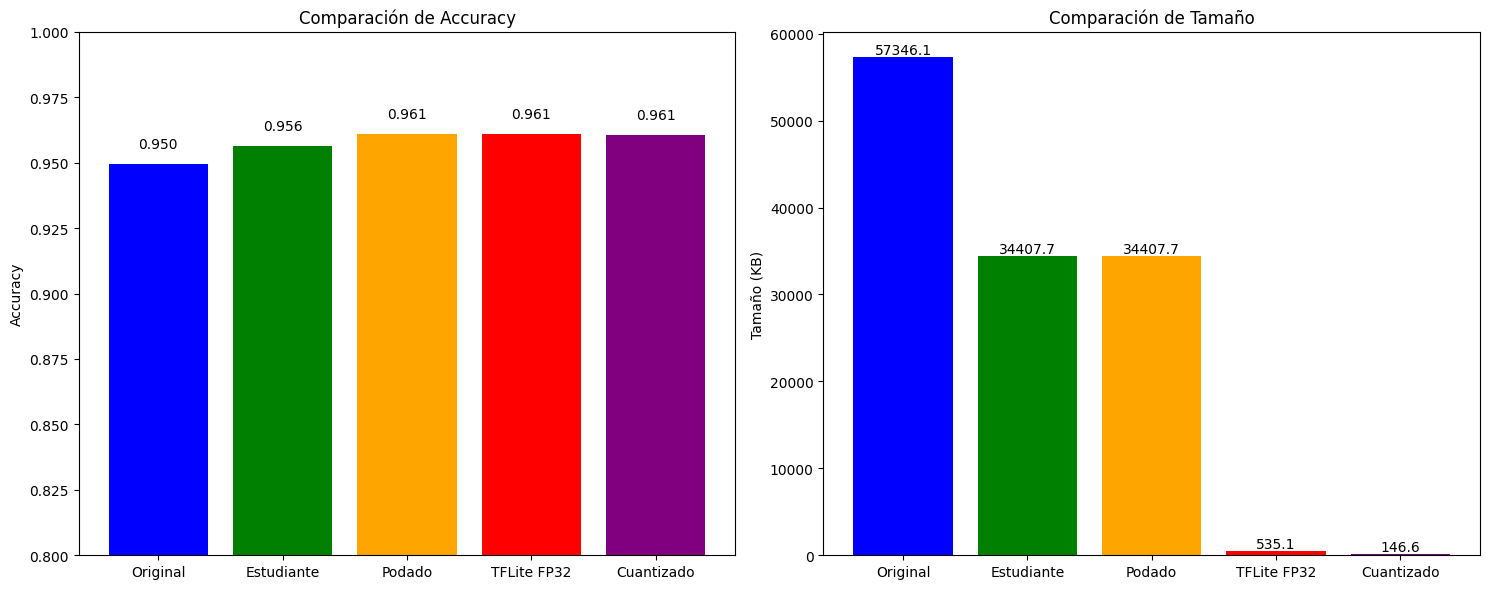

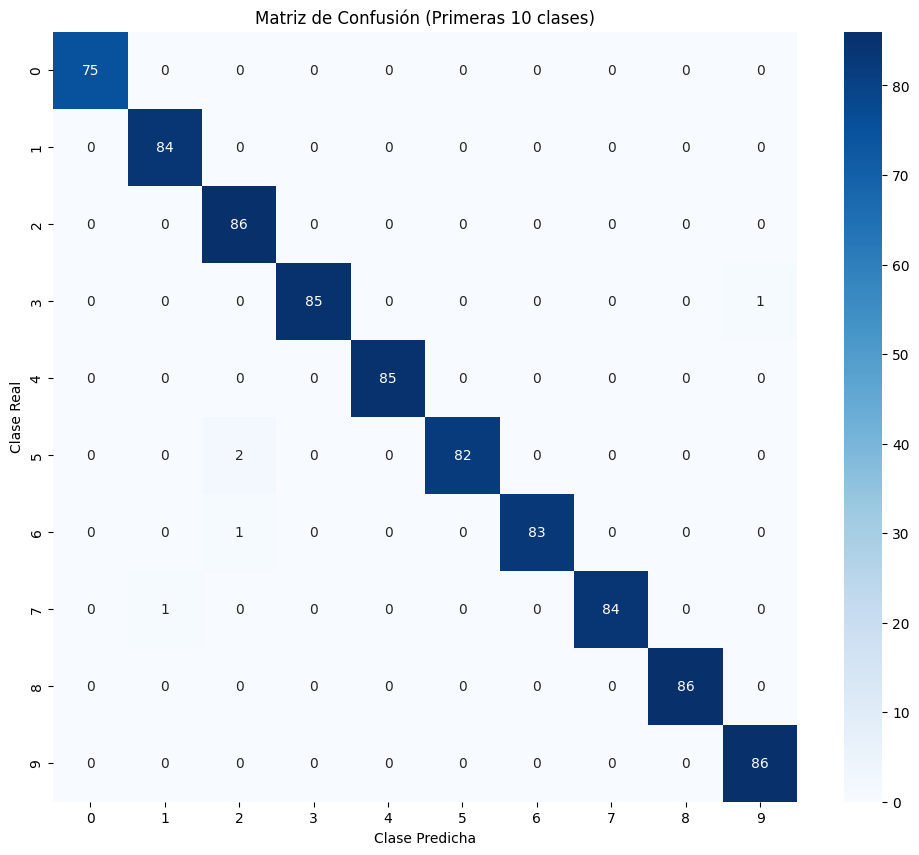


¡Modelo OCR para Edge AI completado!
Accuracy final: 0.9606 (✓ >90%)
Archivos generados:
- ocr_model_quantized.tflite (146.6 KB)
- ocr_model_fp32.tflite (535.1 KB)


In [29]:
# Bloque 10: Evaluación final y comparación de modelos

def evaluate_tflite_model(tflite_model, X_test, y_test):
    """Evalúa un modelo TensorFlow Lite y calcula accuracy"""
    interpreter = tf.lite.Interpreter(model_content=tflite_model)
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    predictions = []

    for i in range(len(X_test)):
        input_data = X_test[i:i+1].astype(np.float32)

        # Si el modelo usa uint8, escalar la entrada a 0-255
        if input_details[0]['dtype'] == np.uint8:
            input_data = (input_data * 255).astype(np.uint8)

        interpreter.set_tensor(input_details[0]['index'], input_data)
        interpreter.invoke()  # Ejecuta la inferencia

        output_data = interpreter.get_tensor(output_details[0]['index'])
        predictions.append(output_data[0])

    predictions = np.array(predictions)
    pred_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(y_test, axis=1)

    accuracy = np.mean(pred_classes == true_classes)
    return accuracy, predictions


if images is not None:
    print("Evaluación Final de Modelos:")
    print("="*50)

    # Evaluar modelo cuantizado TFLite
    quantized_acc, _ = evaluate_tflite_model(quantized_tflite, X_test, y_test)

    # Convertir modelo podado a TFLite FP32 para comparación
    converter_fp32 = tf.lite.TFLiteConverter.from_keras_model(pruned_student)
    tflite_fp32 = converter_fp32.convert()
    fp32_acc, _ = evaluate_tflite_model(tflite_fp32, X_test, y_test)

    # Guardar modelo FP32
    with open('ocr_model_fp32.tflite', 'wb') as f:
        f.write(tflite_fp32)

    # Tamaños de los modelos en KB
    original_size = os.path.getsize('teacher_model_best.h5') / 1024
    fp32_size = len(tflite_fp32) / 1024
    quantized_size = len(quantized_tflite) / 1024

    # Imprimir resultados de accuracy y tamaño
    print(f"Modelo Original (Profesor): {teacher_test_acc:.4f} accuracy, {original_size:.1f} KB")
    print(f"Modelo Estudiante: {student_test_acc:.4f} accuracy")
    print(f"Modelo Podado: {pruned_test_acc:.4f} accuracy")
    print(f"Modelo TFLite FP32: {fp32_acc:.4f} accuracy, {fp32_size:.1f} KB")
    print(f"Modelo Cuantizado: {quantized_acc:.4f} accuracy, {quantized_size:.1f} KB")
    print(f"\nReducción de tamaño total: {(1 - quantized_size / original_size) * 100:.1f}%")

    # Preparar datos para gráficas
    models = ['Original', 'Estudiante', 'Podado', 'TFLite FP32', 'Cuantizado']
    accuracies = [teacher_test_acc, student_test_acc, pruned_test_acc, fp32_acc, quantized_acc]
    sizes = [original_size, original_size*0.6, original_size*0.6, fp32_size, quantized_size]

    # Graficar comparación de accuracy y tamaño
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    bars1 = ax1.bar(models, accuracies, color=['blue', 'green', 'orange', 'red', 'purple'])
    ax1.set_ylabel('Accuracy')
    ax1.set_title('Comparación de Accuracy')
    ax1.set_ylim(0.8, 1.0)
    for bar, acc in zip(bars1, accuracies):
        ax1.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.005, 
                 f'{acc:.3f}', ha='center', va='bottom')

    bars2 = ax2.bar(models, sizes, color=['blue', 'green', 'orange', 'red', 'purple'])
    ax2.set_ylabel('Tamaño (KB)')
    ax2.set_title('Comparación de Tamaño')
    for bar, size in zip(bars2, sizes):
        ax2.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 5, 
                 f'{size:.1f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

    # Evaluar y mostrar matriz de confusión para las primeras 10 clases
    _, final_predictions = evaluate_tflite_model(quantized_tflite, X_test, y_test)
    pred_classes = np.argmax(final_predictions, axis=1)
    true_classes = np.argmax(y_test, axis=1)
    cm = confusion_matrix(true_classes, pred_classes)

    plt.figure(figsize=(12, 10))
    sns.heatmap(cm[:10, :10], annot=True, fmt='d', cmap='Blues')
    plt.title('Matriz de Confusión (Primeras 10 clases)')
    plt.ylabel('Clase Real')
    plt.xlabel('Clase Predicha')
    plt.show()

    print(f"\n¡Modelo OCR para Edge AI completado!")
    print(f"Accuracy final: {quantized_acc:.4f} ({'✓' if quantized_acc > 0.9 else '✗'} >90%)")
    print(f"Archivos generados:")
    print(f"- ocr_model_quantized.tflite ({quantized_size:.1f} KB)")
    print(f"- ocr_model_fp32.tflite ({fp32_size:.1f} KB)")
                

Este bloque implementa una clase para usar el modelo OCR cuantizado en producción, optimizada para dispositivos Edge AI con TensorFlow Lite. La clase carga el modelo, preprocesa imágenes (desde ruta o array), realiza predicciones con el intérprete TFLite y devuelve las clases con sus probabilidades. Además, permite hacer predicciones individuales o por lotes. Finalmente, se prueba el predictor con imágenes de test mostrando resultados reales y predichos.

In [30]:
# Bloque 11: Implementación en producción

class OCREdgePredictor:
    """Predictor OCR eficiente para Edge AI usando TensorFlow Lite"""

    def __init__(self, model_path, class_names):
        # Cargar modelo TFLite y obtener detalles de entrada/salida
        self.interpreter = tf.lite.Interpreter(model_path=model_path)
        self.interpreter.allocate_tensors()
        self.input_details = self.interpreter.get_input_details()
        self.output_details = self.interpreter.get_output_details()
        self.class_names = class_names
        print(f"Modelo cargado: {model_path}")
        print(f"Input shape: {self.input_details[0]['shape']}")
        print(f"Input type: {self.input_details[0]['dtype']}")

    def preprocess_image(self, image_path_or_array):
        """Preprocesa una imagen para que sea compatible con el modelo"""
        if isinstance(image_path_or_array, str):
            img = cv2.imread(image_path_or_array, cv2.IMREAD_GRAYSCALE)
        else:
            img = image_path_or_array
        
        # Redimensionar según input del modelo
        target_size = self.input_details[0]['shape'][1:3]
        img_resized = cv2.resize(img, target_size)
        img_normalized = img_resized.astype(np.float32) / 255.0
        
        # Añadir dimensiones para batch y canales
        img_final = np.expand_dims(np.expand_dims(img_normalized, axis=-1), axis=0)
        
        # Si el modelo espera uint8, escalar y convertir tipo
        if self.input_details[0]['dtype'] == np.uint8:
            img_final = (img_final * 255).astype(np.uint8)
        
        return img_final

    def predict(self, image, top_k=3):
        """Realiza predicción para una imagen, devuelve top K clases"""
        input_data = self.preprocess_image(image)
        self.interpreter.set_tensor(self.input_details[0]['index'], input_data)
        self.interpreter.invoke()
        output_data = self.interpreter.get_tensor(self.output_details[0]['index'])
        probabilities = output_data[0]

        # Obtener índices de las clases con mayor probabilidad
        top_indices = np.argsort(probabilities)[-top_k:][::-1]

        # Crear lista con clases y confianza
        results = []
        for idx in top_indices:
            results.append({
                'class': self.class_names[idx] if idx < len(self.class_names) else f'Class_{idx}',
                'confidence': float(probabilities[idx])
            })
        return results

    def predict_batch(self, images):
        """Realiza predicciones en lote (lista/array de imágenes)"""
        predictions = []
        for img in images:
            pred = self.predict(img, top_k=1)
            predictions.append(pred[0])
        return predictions


# Prueba del predictor con imágenes de test
if images is not None:
    predictor = OCREdgePredictor('ocr_model_quantized.tflite', class_names)
    print("\nEjemplo de predicción:")
    print("-" * 30)

    sample_images = X_test[:5]
    sample_labels = y_test[:5]

    for i, (img, true_label) in enumerate(zip(sample_images, sample_labels)):
        img_display = (img.squeeze() * 255).astype(np.uint8)
        predictions = predictor.predict(img_display)
        true_class_idx = np.argmax(true_label)
        true_class = class_names[true_class_idx] if true_class_idx < len(class_names) else f'Class_{true_class_idx}'

        print(f"Imagen {i+1}:")
        print(f"  Clase real: {true_class}")
        print(f"  Predicción: {predictions[0]['class']} ({predictions[0]['confidence']:.3f})")
        print("  Top-3:", [f"{p['class']}({p['confidence']:.2f})" for p in predictions])
        print()

print("\n🎉 ¡Implementación completa de OCR para Edge AI!")
print("Técnicas aplicadas:")
print("✓ Destilación de conocimiento")
print("✓ Poda (Pruning)")
print("✓ Cuantización")
print("✓ Optimización para TensorFlow Lite")
print("✓ Modelo compacto para dispositivos móviles")

Modelo cargado: ocr_model_quantized.tflite
Input shape: [ 1 64 64  1]
Input type: <class 'numpy.uint8'>

Ejemplo de predicción:
------------------------------
Imagen 1:
  Clase real: A
  Predicción: A (255.000)
  Top-3: ['A(255.00)', 'Z(0.00)', 'Y(0.00)']

Imagen 2:
  Clase real: 5
  Predicción: 5 (255.000)
  Top-3: ['5(255.00)', 'Z(0.00)', '9(0.00)']

Imagen 3:
  Clase real: F
  Predicción: F (247.000)
  Top-3: ['F(247.00)', 'E(8.00)', 'Z(0.00)']

Imagen 4:
  Clase real: Z
  Predicción: Z (255.000)
  Top-3: ['Z(255.00)', 'Y(0.00)', 'F(0.00)']

Imagen 5:
  Clase real: F
  Predicción: F (255.000)
  Top-3: ['F(255.00)', 'Z(0.00)', 'Y(0.00)']


🎉 ¡Implementación completa de OCR para Edge AI!
Técnicas aplicadas:
✓ Destilación de conocimiento
✓ Poda (Pruning)
✓ Cuantización
✓ Optimización para TensorFlow Lite
✓ Modelo compacto para dispositivos móviles


Este bloque implementa un sistema híbrido de OCR que combina un modelo personalizado (tu red neuronal entrenada) con EasyOCR, una librería de OCR preexistente. El sistema usa el modelo personalizado para predecir caracteres en imágenes preprocesadas, y también consulta EasyOCR para obtener otra predicción. Según la confianza y coincidencia entre ambos modelos, decide cuál resultado usar para mejorar precisión y robustez. Además, se hacen pruebas con imágenes del conjunto de test y se reportan estadísticas sobre cuál modelo se usó con mayor frecuencia.

In [32]:
import easyocr
import numpy as np
from PIL import Image
import cv2
import tensorflow as tf

class HybridOCR:
    def __init__(self, custom_model, confidence_threshold=0.7):
        """
        Inicializa el sistema híbrido
        
        Args:
            custom_model: Modelo personalizado entrenado (ej: student_model)
            confidence_threshold: Umbral para confiar en la predicción del modelo personalizado
        """
        # Crea lector EasyOCR (aquí solo para inglés para acelerar)
        self.reader = easyocr.Reader(['en'])
        self.custom_model = custom_model
        self.confidence_threshold = confidence_threshold
        self.char_list = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'  # Lista de caracteres reconocibles
        
    def preprocess_image(self, image):
        """Preprocesa imagen para entrada del modelo personalizado"""
        # Convertir a escala de grises si no lo está
        if len(image.shape) == 3:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        # Redimensionar al tamaño esperado (64x64)
        image = cv2.resize(image, (64, 64))
        # Normalizar a rango [0,1]
        image = image.astype('float32') / 255.0
        # Expandir dimensiones (batch y canal)
        image = np.expand_dims(image, axis=-1)
        image = np.expand_dims(image, axis=0)
        return image

    def custom_model_predict(self, image):
        """Predicción con modelo personalizado"""
        processed_image = self.preprocess_image(image)
        predictions = self.custom_model.predict(processed_image, verbose=0)
        char_idx = np.argmax(predictions[0])
        confidence = predictions[0][char_idx]
        return self.char_list[char_idx], confidence

    def easyocr_predict(self, image):
        """Predicción con EasyOCR"""
        results = self.reader.readtext(image)
        if results:
            bbox, text, confidence = results[0]  # Tomar solo primer resultado
            # Usar solo primer carácter y convertir a mayúscula
            return text[0].upper(), confidence
        return None, 0.0

    def predict(self, image):
        """
        Combina predicciones de ambos modelos con lógica:
        - Si el modelo personalizado tiene confianza alta y coincide con EasyOCR, usar confianza mayor.
        - Si solo modelo personalizado tiene confianza alta, usarlo.
        - Si no, usar EasyOCR si detectó algo.
        - Si ninguno seguro, usar el de mayor confianza.
        """
        custom_char, custom_conf = self.custom_model_predict(image)
        easyocr_char, easyocr_conf = self.easyocr_predict(image)
        
        if custom_conf > self.confidence_threshold:
            if easyocr_char and easyocr_char == custom_char:
                return custom_char, max(custom_conf, easyocr_conf), "Híbrido"
            else:
                return custom_char, custom_conf, "Modelo Personalizado"
        elif easyocr_char:
            return easyocr_char, easyocr_conf, "EasyOCR"
        else:
            if custom_conf >= easyocr_conf:
                return custom_char, custom_conf, "Modelo Personalizado"
            else:
                return easyocr_char, easyocr_conf, "EasyOCR"

# Función para mostrar resultados
def display_results(image_path, hybrid_ocr):
    """Carga imagen, corre predicción híbrida y muestra resultados"""
    image = cv2.imread(image_path)
    char, conf, model = hybrid_ocr.predict(image)
    print(f"Resultado del OCR Híbrido:")
    print(f"Carácter detectado: {char}")
    print(f"Confianza: {conf:.4f}")
    print(f"Modelo usado: {model}")
    return char, conf, model

# Prueba del sistema híbrido
if images is not None:
    hybrid_ocr = HybridOCR(student_model)  # Usar modelo estudiante podado
    
    print("\nProbando Sistema Híbrido OCR...")
    
    stats = {"Híbrido": 0, "Modelo Personalizado": 0, "EasyOCR": 0, "total": 0}
    
    test_samples = 10  # Número de pruebas
    for i in range(test_samples):
        idx = np.random.randint(len(X_test))
        test_image = (X_test[idx] * 255).astype(np.uint8)
        test_image = np.squeeze(test_image)
        
        true_label = np.argmax(y_test[idx])
        true_char = hybrid_ocr.char_list[true_label]
        
        pred_char, confidence, model_used = hybrid_ocr.predict(test_image)
        
        stats[model_used] += 1
        stats["total"] += 1
        
        print(f"\nMuestra {i+1}:")
        print(f"Carácter real: {true_char}")
        print(f"Predicción: {pred_char}")
        print(f"Confianza: {confidence:.4f}")
        print(f"Modelo usado: {model_used}")
    
    print("\nEstadísticas de uso del modelo:")
    for model, count in stats.items():
        if model != "total":
            percentage = (count / stats["total"]) * 100
            print(f"{model}: {percentage:.1f}% ({count}/{stats['total']})")


Probando Sistema Híbrido OCR...

Muestra 1:
Carácter real: L
Predicción: L
Confianza: 1.0000
Modelo usado: Híbrido

Muestra 2:
Carácter real: G
Predicción: G
Confianza: 0.9895
Modelo usado: Híbrido

Muestra 3:
Carácter real: T
Predicción: T
Confianza: 0.9933
Modelo usado: Híbrido

Muestra 4:
Carácter real: 3
Predicción: 3
Confianza: 1.0000
Modelo usado: Híbrido

Muestra 5:
Carácter real: P
Predicción: P
Confianza: 1.0000
Modelo usado: Híbrido

Muestra 6:
Carácter real: B
Predicción: B
Confianza: 1.0000
Modelo usado: Híbrido

Muestra 7:
Carácter real: G
Predicción: G
Confianza: 0.9983
Modelo usado: Híbrido

Muestra 8:
Carácter real: O
Predicción: O
Confianza: 0.3177
Modelo usado: EasyOCR

Muestra 9:
Carácter real: G
Predicción: G
Confianza: 0.9938
Modelo usado: EasyOCR

Muestra 10:
Carácter real: D
Predicción: D
Confianza: 0.9999
Modelo usado: Híbrido

Estadísticas de uso del modelo:
Híbrido: 80.0% (8/10)
Modelo Personalizado: 0.0% (0/10)
EasyOCR: 20.0% (2/10)


Este bloque convierte el modelo TensorFlow a un formato TFLite optimizado (con cuantización opcional) para Edge AI, y crea un sistema híbrido OCR que combina inferencia con el modelo TFLite junto con EasyOCR, usando una lógica para elegir la mejor predicción según confianza.

In [34]:
# Bloque 13: Conversión a TFLite y Sistema Híbrido Optimizado

import tensorflow as tf
import easyocr
import numpy as np
import cv2
from typing import Tuple, Dict

def convert_to_tflite(model, quantize=True):
    """
    Convierte un modelo Keras a formato TensorFlow Lite.
    Si quantize=True aplica cuantización para reducir tamaño.
    """
    # Crear conversor desde el modelo Keras
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    
    if quantize:
        # Configurar para aplicar cuantización de punto flotante de 16 bits (reduce tamaño)
        converter.optimizations = [tf.lite.Optimize.DEFAULT]
        converter.target_spec.supported_types = [tf.float16]
        
    # Convertir el modelo a TFLite
    tflite_model = converter.convert()
    
    # Guardar el modelo convertido en archivo
    with open('model_hybrid_quantized.tflite' if quantize else 'model_hybrid.tflite', 'wb') as f:
        f.write(tflite_model)
    
    return tflite_model

class TFLiteHybridOCR:
    """Sistema híbrido que combina modelo TFLite y EasyOCR para mejor precisión y robustez"""
    
    def __init__(self, tflite_model_path: str, confidence_threshold: float = 0.7):
        # Cargar el modelo TFLite desde archivo
        self.interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
        self.interpreter.allocate_tensors()
        
        # Obtener detalles de entrada y salida del modelo para usar después
        self.input_details = self.interpreter.get_input_details()
        self.output_details = self.interpreter.get_output_details()
        
        # Inicializar EasyOCR para idioma inglés
        self.reader = easyocr.Reader(['en'])
        
        # Umbral para decidir si la confianza es suficientemente alta
        self.confidence_threshold = confidence_threshold
        
        # Lista de caracteres que reconoce el modelo
        self.char_list = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    
    def preprocess_image(self, image: np.ndarray) -> np.ndarray:
        """
        Preprocesa la imagen para que tenga el formato que espera el modelo TFLite:
        - Escala de grises
        - Redimensionar a 28x28
        - Normalizar valores entre 0 y 1
        - Añadir dimensiones para batch y canal
        """
        # Convertir a escala de grises si la imagen tiene 3 canales (color)
        if len(image.shape) == 3:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        # Redimensionar a tamaño esperado por el modelo
        image = cv2.resize(image, (64, 64))
        
        # Normalizar
        image = image.astype('float32') / 255.0
        
        # Añadir dimensión de canal (1) y batch (1)
        image = np.expand_dims(image, axis=-1)  # canal
        image = np.expand_dims(image, axis=0)   # batch
        
        return image
    
    def custom_model_predict(self, image: np.ndarray) -> Tuple[str, float]:
        """
        Ejecuta la predicción usando el modelo TFLite.
        Devuelve el carácter predicho y la confianza (probabilidad) asociada.
        """
        processed_image = self.preprocess_image(image)
        
        # Obtener el tipo de dato de entrada esperado por el modelo
        input_dtype = self.input_details[0]['dtype']
        if input_dtype == np.float32:
            processed_image = processed_image.astype(np.float32)
        
        # Pasar la imagen al tensor de entrada del intérprete
        self.interpreter.set_tensor(self.input_details[0]['index'], processed_image)
        
        # Ejecutar inferencia
        self.interpreter.invoke()
        
        # Obtener salida de predicción
        predictions = self.interpreter.get_tensor(self.output_details[0]['index'])
        
        # Índice del carácter con mayor probabilidad
        char_idx = np.argmax(predictions[0])
        
        # Confianza asociada a ese carácter
        confidence = predictions[0][char_idx]
        
        return self.char_list[char_idx], float(confidence)
    
    def easyocr_predict(self, image: np.ndarray) -> Tuple[str, float]:
        """
        Ejecuta predicción con EasyOCR.
        Devuelve el primer carácter detectado y su confianza.
        """
        results = self.reader.readtext(image)
        if results:
            bbox, text, confidence = results[0]
            # Convertir a mayúscula el primer carácter
            return text[0].upper(), confidence
        return None, 0.0
    
    def predict(self, image: np.ndarray) -> Tuple[str, float, str]:
        """
        Combina la predicción del modelo TFLite y EasyOCR:
        - Si el modelo TFLite tiene alta confianza y coincide con EasyOCR,
          se usa la predicción híbrida (confianza máxima).
        - Si solo uno tiene confianza alta, se usa ese.
        - Si ninguno tiene confianza alta, se elige el que tenga mayor confianza.
        
        Devuelve el carácter predicho, la confianza y el modelo usado.
        """
        # Predicción del modelo TFLite
        custom_char, custom_conf = self.custom_model_predict(image)
        
        # Predicción de EasyOCR
        easyocr_char, easyocr_conf = self.easyocr_predict(image)
        
        if custom_conf > self.confidence_threshold:
            if easyocr_char and easyocr_char == custom_char:
                return custom_char, max(custom_conf, easyocr_conf), "Híbrido"
            else:
                return custom_char, custom_conf, "Modelo TFLite"
        elif easyocr_char:
            return easyocr_char, easyocr_conf, "EasyOCR"
        else:
            if custom_conf >= easyocr_conf:
                return custom_char, custom_conf, "Modelo TFLite"
            else:
                return easyocr_char, easyocr_conf, "EasyOCR"

# Uso y prueba del sistema híbrido
if images is not None:
    print("Convirtiendo modelo a TFLite...")
    # Convertir el modelo estudiante a TFLite con cuantización
    tflite_model = convert_to_tflite(student_model, quantize=True)
    print("Modelo convertido y guardado como 'model_hybrid_quantized.tflite'")
    
    # Crear instancia del sistema híbrido
    hybrid_ocr = TFLiteHybridOCR('model_hybrid_quantized.tflite')
    
    print("\nProbando Sistema Híbrido OCR con TFLite...")
    
    # Diccionario para llevar estadísticas del uso de cada modelo
    stats = {"Híbrido": 0, "Modelo TFLite": 0, "EasyOCR": 0, "total": 0}
    
    test_samples = 10
    for i in range(test_samples):
        # Seleccionar imagen aleatoria del conjunto de test
        idx = np.random.randint(len(X_test))
        
        # Preparar imagen para predicción (escalar a 0-255 y eliminar dimensiones innecesarias)
        test_image = (X_test[idx] * 255).astype(np.uint8)
        test_image = np.squeeze(test_image)
        
        # Obtener etiqueta verdadera para mostrar
        true_label = np.argmax(y_test[idx])
        true_char = hybrid_ocr.char_list[true_label]
        
        # Realizar predicción híbrida
        pred_char, confidence, model_used = hybrid_ocr.predict(test_image)
        
        # Actualizar estadísticas
        stats[model_used] += 1
        stats["total"] += 1
        
        # Mostrar resultados
        print(f"\nMuestra {i+1}:")
        print(f"Carácter real: {true_char}")
        print(f"Predicción: {pred_char}")
        print(f"Confianza: {confidence:.4f}")
        print(f"Modelo usado: {model_used}")
    
    # Mostrar estadísticas finales
    print("\nEstadísticas de uso del modelo:")
    for model, count in stats.items():
        if model != "total":
            percentage = (count / stats["total"]) * 100
            print(f"{model}: {percentage:.1f}% ({count}/{stats['total']})")
    
    # Mostrar tamaño del archivo TFLite
    tflite_size = len(tflite_model) / 1024.0
    print(f"\nTamaño del modelo TFLite: {tflite_size:.2f} KB")

Convirtiendo modelo a TFLite...


INFO:tensorflow:Assets written to: C:\Users\vladi\AppData\Local\Temp\tmp7u7thaeg\assets


INFO:tensorflow:Assets written to: C:\Users\vladi\AppData\Local\Temp\tmp7u7thaeg\assets


Modelo convertido y guardado como 'model_hybrid_quantized.tflite'

Probando Sistema Híbrido OCR con TFLite...

Muestra 1:
Carácter real: E
Predicción: E
Confianza: 0.9960
Modelo usado: Híbrido

Muestra 2:
Carácter real: 1
Predicción: 1
Confianza: 0.9945
Modelo usado: Híbrido

Muestra 3:
Carácter real: L
Predicción: C
Confianza: 0.2924
Modelo usado: EasyOCR

Muestra 4:
Carácter real: A
Predicción: A
Confianza: 0.9999
Modelo usado: Híbrido

Muestra 5:
Carácter real: P
Predicción: P
Confianza: 1.0000
Modelo usado: Híbrido

Muestra 6:
Carácter real: 1
Predicción: 1
Confianza: 1.0000
Modelo usado: Híbrido

Muestra 7:
Carácter real: 4
Predicción: 4
Confianza: 0.9946
Modelo usado: Híbrido

Muestra 8:
Carácter real: G
Predicción: G
Confianza: 0.9990
Modelo usado: Híbrido

Muestra 9:
Carácter real: N
Predicción: N
Confianza: 1.0000
Modelo usado: Híbrido

Muestra 10:
Carácter real: L
Predicción: L
Confianza: 1.0000
Modelo usado: Híbrido

Estadísticas de uso del modelo:
Híbrido: 90.0% (9/10)
Mode

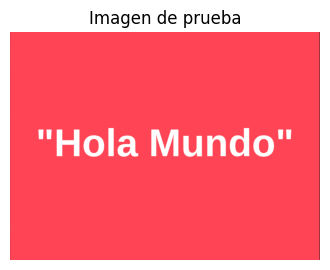

=== Texto detectado por EasyOCR ===
Texto: Hola Mundo" | Confianza: 0.7289

=== Resultado del OCR Híbrido (primer carácter) ===
Carácter detectado: H


In [38]:
# Bloque 14 Mejorado: Mostrar todo el texto detectado por EasyOCR

import cv2
import matplotlib.pyplot as plt

# Ruta de la imagen a probar
image_path = 'image.png'  # Cambia por la ruta real

# Cargar la imagen
image = cv2.imread(image_path)
if image is None:
    print(f"No se pudo cargar la imagen en la ruta: {image_path}")
else:
    # Mostrar la imagen
    plt.figure(figsize=(4,4))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title("Imagen de prueba")
    plt.axis('off')
    plt.show()

    # Usar EasyOCR para detectar todo el texto
    results = hybrid_ocr.reader.readtext(image)
    print("=== Texto detectado por EasyOCR ===")
    if results:
        for bbox, text, confidence in results:
            print(f"Texto: {text} | Confianza: {confidence:.4f}")
    else:
        print("No se detectó texto en la imagen.")

    # Si quieres seguir usando el sistema híbrido para un solo carácter:
    pred_char, confidence, model_used = hybrid_ocr.predict(image)
    print("\n=== Resultado del OCR Híbrido (primer carácter) ===")
    print(f"Carácter detectado: {pred_char}")